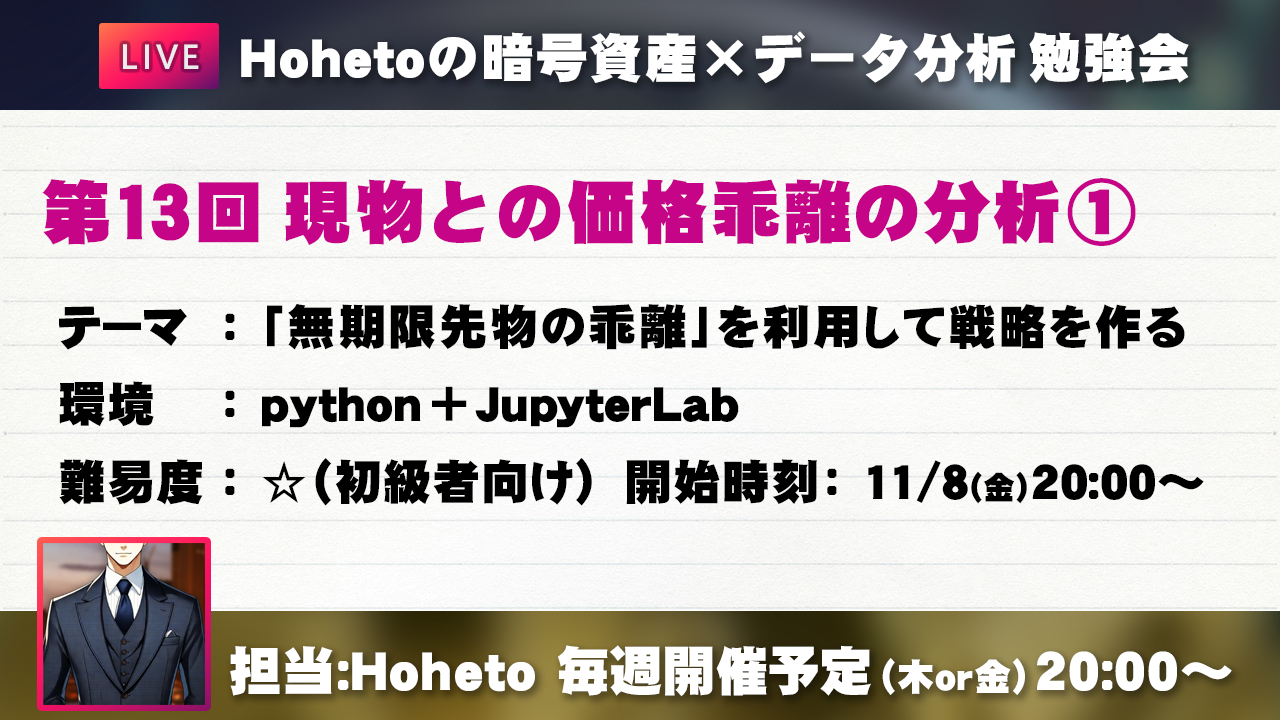

In [1]:
from IPython.display import Image

Image('./images/13_00.png')

# Hoheto勉強会 第13回 現物との価格乖離の分析①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- 現物とデリバティブ（無期限先物）の価格乖離について分析を行います。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆1つ。

# 環境設定

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [4]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# 現物とデリバティブとの価格乖離とは

- 現物取引について
  - ビットコインの現物は様々な取引所で売買されている。
  - 現物とはビットコインのブロックチェーンに記録されているデータそのもの。
  - 例えばCEXで現物を売買したとする。CEX内に保持しているだけであればDB内の1データに過ぎないが、出金すると自分のウォレットの残高が書き換えられる。
- デリバティブ取引について
  - デリバティブとは派生商品のこと。
  - ビットコイン価格に基づいて構築された様々な金融商品。
  - 売買しても、取引所内でのポジションや残高が更新されるだけで、ブロックチェーン上のデータには影響なし。

- なぜデリバティブが使われるか？
  - レバレッジをかけた取引（資金効率アップ）
  - ヘッジ取引
  - ロングやショート、オプションなどを含めた戦略構築

- 現物との価格乖離とはなにか？
  - 現物と比べてデリバティブが買われると、デリバティブ価格＞現物価格となり、上乖離する。
  - 現物と比べてデリバティブが売られると、デリバティブ価格＜現物価格となり、下乖離する。

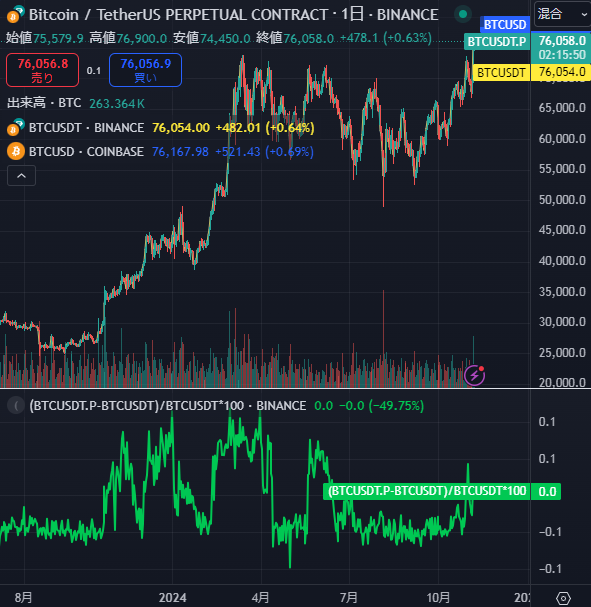

In [5]:
Image('./images/13_01.png', width=700)

- なぜ、このような現象が起きるのか？
  - 一般的に、
  - 強気な上昇相場ではレバレッジをかけたロングポジションが増える or ヘッジショート解消などにより、デリバティブが上乖離する。
  - 弱気な下落相場ではロングポジションの解消 or ヘッジショート or レバレッジをかけたショートポジションなどにより、デリバティブが下乖離する。
- 人の欲望が現れる指標と言える。
  - バブル期には上乖離する。
  - 恐怖のドン底では下乖離する。

- また、短期的な変動、ショートスクイーズやセリクラなどにより、短期間のうちに乖離が跳ね上がるケースがある。
- これは逆張りや押し目の指標となる。

# データ取得

## ビットコイン価格データ取得

- 期間は2021年1月1日～2024年8月31日です。
- 使用データは、
  - Binanceビットコイン先物 BTCUSDT PERP
  - Binanceビットコイン現物 BTCUSDT
  - bybitビットコイン先物 BTCUSDT PERP
  - bybitビットコイン現物 BTCUSDT

In [6]:
apis = {
    'binance_perp': ccxt.binanceusdm(),
    'binance_spot': ccxt.binance(),
    'bybit_perp': ccxt.bybit(),
    'bybit_spot': ccxt.bybit(),
}

- ccxtを利用してOHLCVを取得する関数

In [7]:
from dateutil import parser

def fetch_ohlcv(exchange, symbol, from_date, to_date, timeframe):
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    start_time = from_time
    limit = 1000
    ohlcv_list = []
    while True:
        if type(exchange) == str:
            api = apis[exchange]
        else:
            api = exchange
        ohlcv = api.fetch_ohlcv(symbol=symbol, timeframe=timeframe, since=start_time, limit=limit)
        if len(ohlcv) == 0:
            break
        ohlcv_list += ohlcv
        start_time = ohlcv[-1][0] + 1
        # print(f'{datetime.fromtimestamp(ohlcv[-1][0] / 1000)}')
        if start_time > to_time:
            break
        time.sleep(1)
    df = pd.DataFrame(ohlcv_list)
    df.columns = ['timestamp', 'open', 'high', 'log', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'] / 1000, unit='s', utc=True)
    df = df.set_index('timestamp').sort_index()
    df['ror'] = (df['close'] - df['open']) / df['open']
    df.columns = [f'{exchange}_{column}' for column in df.columns]
    return df

- 相関をプロットする関数

In [8]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

In [9]:
from_date = '2021-01-01'
to_date = '2024-08-31'

In [10]:
ohlcv_1d = {}

- Binance

In [11]:
ohlcv_1d['binance_perp'] = fetch_ohlcv('binance_perp', 'BTC/USDT:USDT', from_date, to_date, '1d')

In [12]:
ohlcv_1d['binance_spot'] = fetch_ohlcv('binance_spot', 'BTC/USDT', from_date, to_date, '1d')

 - bybit

In [13]:
ohlcv_1d['bybit_perp'] = fetch_ohlcv('bybit_perp', 'BTC/USDT:USDT', from_date, to_date, '1d')

In [14]:
ohlcv_1d['bybit_spot'] = fetch_ohlcv('bybit_spot', 'BTC/USDT', from_date, to_date, '1d')

In [15]:
ohlcv_1d['bybit_spot']

,bybit_spot_open,bybit_spot_high,bybit_spot_log,bybit_spot_close,bybit_spot_volume,bybit_spot_ror
timestamp,,,,,,
2021-07-05 00:00:00+00:00,35225.48,35239.23,33187.09,33704.41,13.578128,-0.043181
2021-07-06 00:00:00+00:00,33704.41,35098.33,33578.49,34224.45,3.802583,0.015429
2021-07-07 00:00:00+00:00,34224.45,35008.17,33800.68,33865.30,4.924340,-0.010494
2021-07-08 00:00:00+00:00,33865.30,33921.53,32235.82,32892.17,18.331070,-0.028735
2021-07-09 00:00:00+00:00,32892.17,34077.01,32307.11,33815.88,9.554352,0.028083
...,...,...,...,...,...,...
2024-11-04 00:00:00+00:00,68770.40,69499.39,66830.44,67850.17,21605.880461,-0.013381
2024-11-05 00:00:00+00:00,67850.17,70549.99,67469.49,69376.62,22718.395374,0.022497
2024-11-06 00:00:00+00:00,69376.62,76397.01,69285.85,75578.40,39037.760596,0.089393


- Close価格とRORだけをまとめたDataFrameを作成。

In [16]:
df = pd.concat([ohlcv.filter(regex='_close|_ror') for exchange, ohlcv in ohlcv_1d.items()], axis=1)

In [17]:
df

,binance_perp_close,binance_perp_ror,binance_spot_close,binance_spot_ror,bybit_perp_close,bybit_perp_ror,bybit_spot_close,bybit_spot_ror
timestamp,,,,,,,,
2021-01-01 00:00:00+00:00,29337.16,0.013437,29331.69,0.014108,29325.0,0.013952,NaN,NaN
2021-01-02 00:00:00+00:00,32199.91,0.097581,32178.33,0.097050,32230.0,0.099062,NaN,NaN
2021-01-03 00:00:00+00:00,33054.53,0.026589,33000.05,0.025596,32963.0,0.022743,NaN,NaN
2021-01-04 00:00:00+00:00,32031.07,-0.030945,31988.71,-0.030647,32024.0,-0.028486,NaN,NaN
2021-01-05 00:00:00+00:00,33999.52,0.061505,33949.53,0.061263,34019.5,0.062313,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-11-04 00:00:00+00:00,67834.30,-0.013499,67850.01,-0.013464,67838.7,-0.013163,67850.17,-0.013381
2024-11-05 00:00:00+00:00,69353.10,0.022388,69372.01,0.022432,69345.7,0.022214,69376.62,0.022497
2024-11-06 00:00:00+00:00,75579.90,0.089784,75571.99,0.089373,75599.9,0.090189,75578.40,0.089393


## さっそく現物とデリバティブの乖離を計算

In [18]:
df['binance_dev'] = (df['binance_perp_close'] - df['binance_spot_close']) / df['binance_spot_close']
df['bybit_dev'] = (df['bybit_perp_close'] - df['bybit_spot_close']) / df['bybit_spot_close']

- プロット

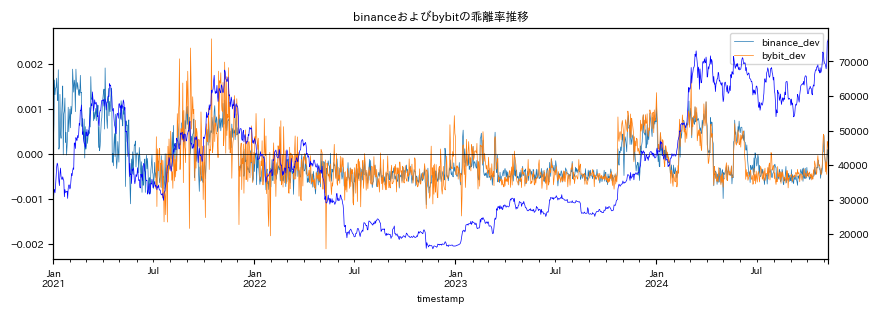

In [19]:
plt.figure(figsize=(10, 3))
plt.title('binanceおよびbybitの乖離率推移')
df['binance_dev'].plot(lw=0.5)
df['bybit_dev'].plot(lw=0.5)
plt.axhline(0, color='k', lw=0.5)
plt.legend()
plt.gca().twinx().plot(df['binance_spot_close'], color='blue', lw=0.5)
plt.show();

- 上げ相場で上乖離し、下げ相場で下乖離している様子がよく分かる。
- binanceでの乖離とbybitでの乖離が同期している様子がわかる。
- bybitのほうが乖離が突っ込んでいる様子がわかる。これは取引所の性質によるものと考えられる
  - 流動性が Binance > bybit
  - レバレッジを嗜好する参加者の割合
  - ヘッジなどの実需ポジションの割合
- ※bybitはBTCUSDTのリニアのperpが登場したのが2021年中旬～だったため、それ以前のデータは存在せず。


## 乖離とリターンの関係

### 乖離 vs リターン

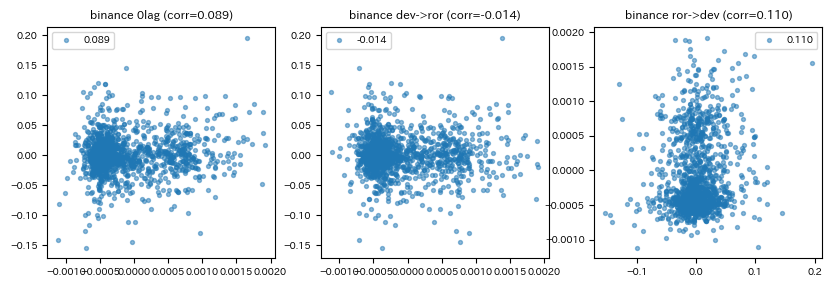

In [20]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_corr(df['binance_dev'], df['binance_perp_ror'], title='binance 0lag')
plt.subplot(1, 3, 2)
plot_corr(df['binance_dev'].shift(1), df['binance_perp_ror'], title='binance dev->ror')
plt.subplot(1, 3, 3)
plot_corr(df['binance_perp_ror'].shift(1), df['binance_dev'], title='binance ror->dev')
plt.show()

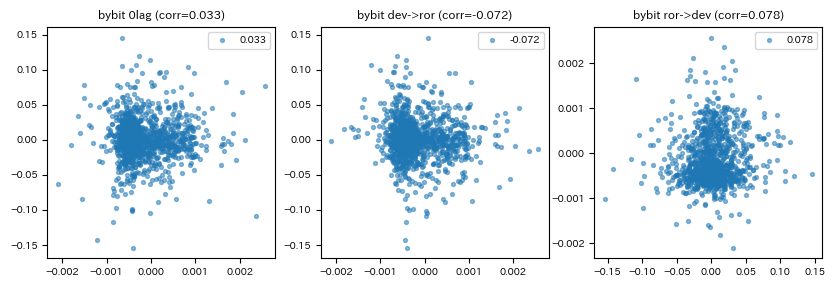

In [21]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_corr(df['bybit_dev'], df['bybit_perp_ror'], title='bybit 0lag')
plt.subplot(1, 3, 2)
plot_corr(df['bybit_dev'].shift(1), df['bybit_perp_ror'], title='bybit dev->ror')
plt.subplot(1, 3, 3)
plot_corr(df['bybit_perp_ror'].shift(1), df['bybit_dev'], title='bybit ror->dev')
plt.show()

- さほど傾向が見られない

### 乖離変化 vs リターン

In [22]:
df['binance_dev_diff'] = df['binance_dev'].diff()
df['bybit_dev_diff'] = df['bybit_dev'].diff()

- 相関をチェック。

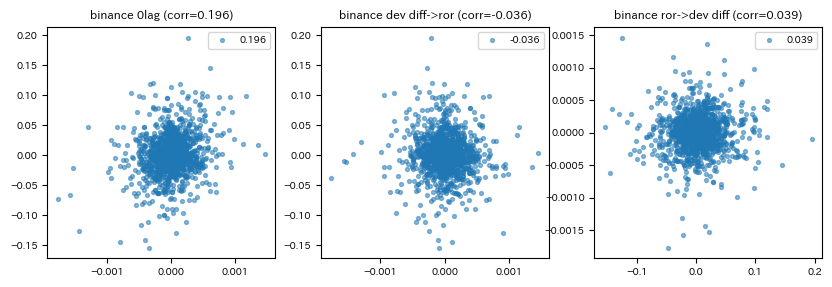

In [23]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_corr(df['binance_dev_diff'], df['binance_perp_ror'], title='binance 0lag')
plt.subplot(1, 3, 2)
plot_corr(df['binance_dev_diff'].shift(1), df['binance_perp_ror'], title='binance dev diff->ror')
plt.subplot(1, 3, 3)
plot_corr(df['binance_perp_ror'].shift(1), df['binance_dev_diff'], title='binance ror->dev diff')
plt.show()

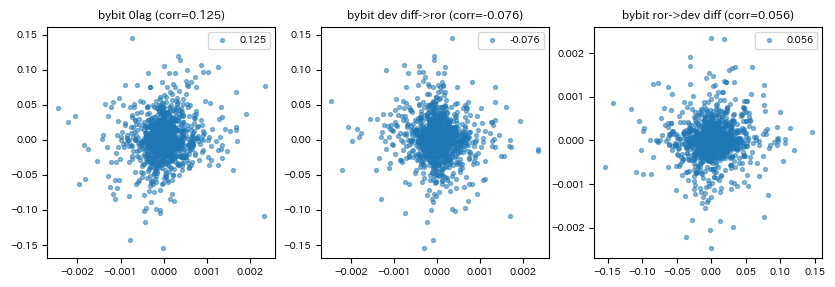

In [24]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_corr(df['bybit_dev_diff'], df['bybit_perp_ror'], title='bybit 0lag')
plt.subplot(1, 3, 2)
plot_corr(df['bybit_dev_diff'].shift(1), df['bybit_perp_ror'], title='bybit dev diff->ror')
plt.subplot(1, 3, 3)
plot_corr(df['bybit_perp_ror'].shift(1), df['bybit_dev_diff'], title='bybit ror->dev diff')
plt.show()

- 当日の乖離変化と当日のリターンに相関が見られる。
  - 価格が上がれば乖離が上がりやすい、ということ。
- 前日の乖離変化とリターンに、弱い逆相関が見られる→これは乖離の逆行を意味する。
  - つまり、乖離が上がればそれを咎めて価格が下がる、ということ。

# 戦略作成

- いくつかパターンを考える。

- さきほどのグラフ。

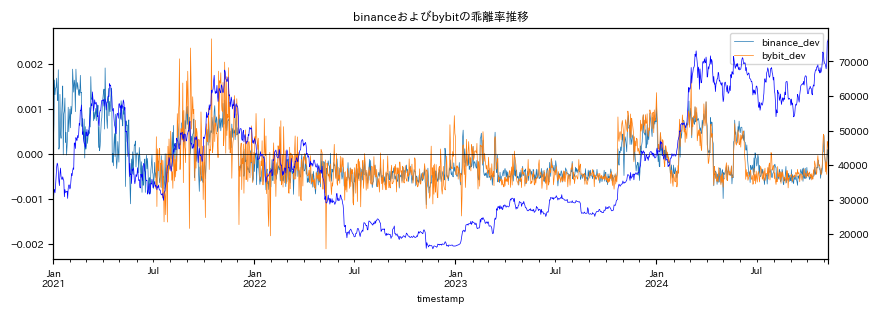

In [25]:
plt.figure(figsize=(10, 3))
plt.title('binanceおよびbybitの乖離率推移')
df['binance_dev'].plot(lw=0.5)
df['bybit_dev'].plot(lw=0.5)
plt.axhline(0, color='k', lw=0.5)
plt.legend()
plt.gca().twinx().plot(df['binance_spot_close'], color='blue', lw=0.5)
plt.show();

## 戦略1

- 平滑化乖離（移動平均で平滑化する）がプラス水準であればロング、マイナス水準であればショート

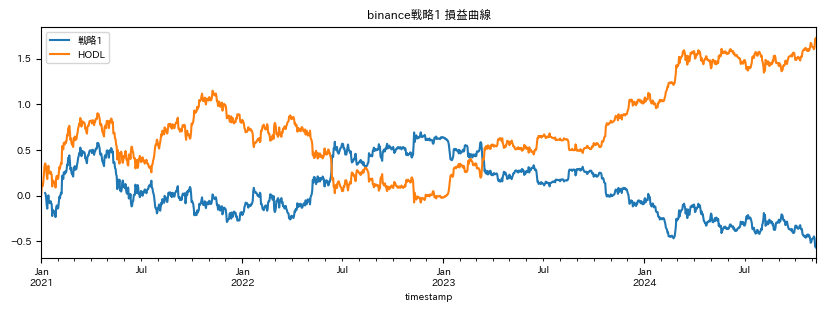

In [26]:
strategy1 = df.copy()
strategy1['binance_dev_sma_s1'] = strategy1['binance_dev'].rolling(7).mean().shift(1)
strategy1['signal'] = np.sign(strategy1['binance_dev_sma_s1'])
strategy1['pnl'] = strategy1['binance_perp_ror'] * strategy1['signal']
plt.figure(figsize=(10, 3))
plt.title('binance戦略1 損益曲線')
strategy1['pnl'].cumsum().plot(label='戦略1')
strategy1['binance_perp_ror'].cumsum().plot(label='HODL')
plt.legend();

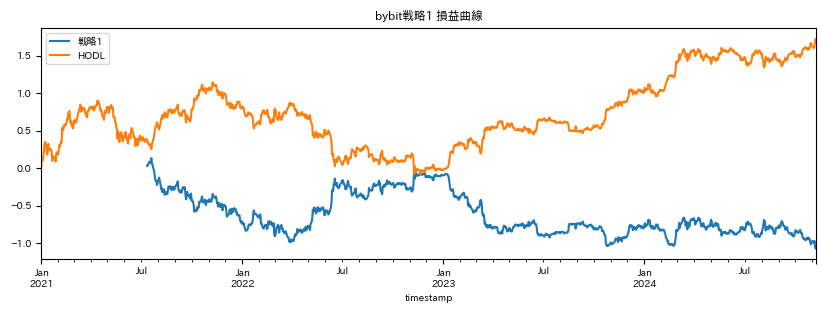

In [27]:
strategy1 = df.copy()
strategy1['bybit_dev_sma_s1'] = strategy1['bybit_dev'].rolling(7).mean().shift(1)
strategy1['signal'] = np.sign(strategy1['bybit_dev_sma_s1'])
strategy1['pnl'] = strategy1['bybit_perp_ror'] * strategy1['signal']
plt.figure(figsize=(10, 3))
plt.title('bybit戦略1 損益曲線')
strategy1['pnl'].cumsum().plot(label='戦略1')
strategy1['bybit_perp_ror'].cumsum().plot(label='HODL')
plt.legend();

## 戦略2

- 前日の乖離変化がマイナスであればロング、プラスであればショート（乖離変化に逆張り）

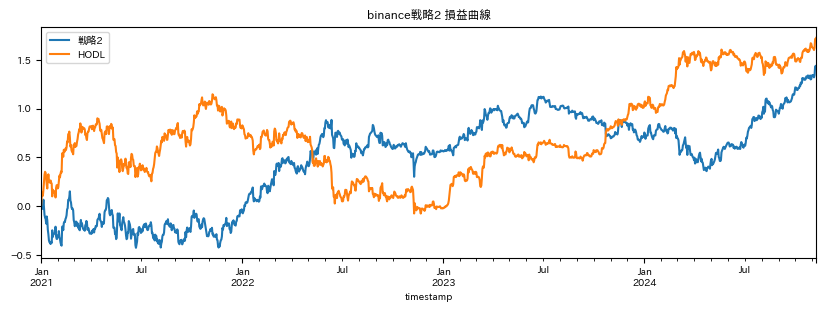

In [28]:
strategy2 = df.copy()
strategy2['binance_dev_diff_s1'] = strategy2['binance_dev_diff'].shift(1)
strategy2['signal'] = -np.sign(strategy2['binance_dev_diff_s1'])
strategy2['pnl'] = strategy2['binance_perp_ror'] * strategy2['signal']

plt.figure(figsize=(10, 3))
plt.title('binance戦略2 損益曲線')
strategy2['pnl'].cumsum().plot(label='戦略2')
strategy2['binance_perp_ror'].cumsum().plot(label='HODL')
plt.legend();

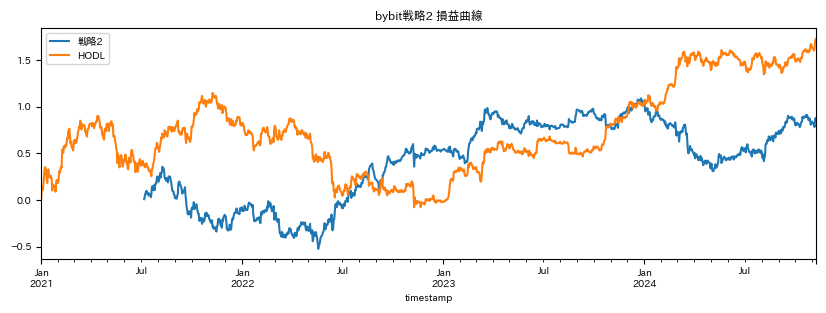

In [29]:
strategy2 = df.copy()
strategy2['bybit_dev_diff_s1'] = strategy2['bybit_dev_diff'].shift(1)
strategy2['signal'] = -np.sign(strategy2['bybit_dev_diff_s1'])
strategy2['pnl'] = strategy2['bybit_perp_ror'] * strategy2['signal']

plt.figure(figsize=(10, 3))
plt.title('bybit戦略2 損益曲線')
strategy2['pnl'].cumsum().plot(label='戦略2')
strategy2['bybit_perp_ror'].cumsum().plot(label='HODL')
plt.legend();

## 指標をきれいにしてみる

- 指標がイマイチなので変換してみる。

- 一応、ADF検定では乖離と乖離変化は定常だと出ている

In [30]:
from statsmodels.tsa.stattools import adfuller

In [31]:
adf_result = adfuller(df['binance_dev'].dropna())
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value      : {adf_result[1]:.4f}')

ADF Statistic: -4.8126
p-value      : 0.0001


In [32]:
adf_result = adfuller(df['binance_dev_diff'].dropna())
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value      : {adf_result[1]:.4f}')

ADF Statistic: -10.1583
p-value      : 0.0000


- しかし、プロットを見る限り、明らかに時期によって平均や分散が異なっている。

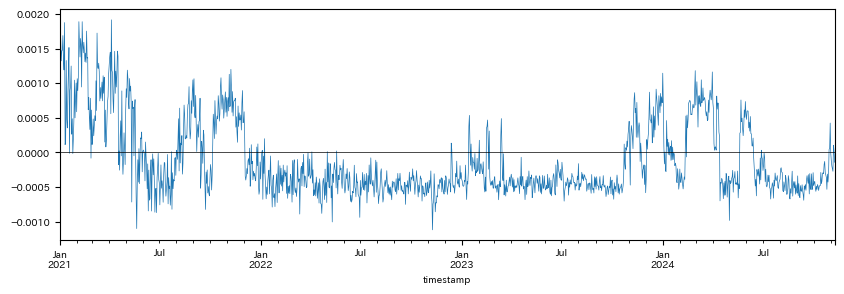

In [33]:
plt.figure(figsize=(10, 3))
df['binance_dev'].plot(lw=0.5)
plt.axhline(0, color='k', lw=0.5);

- ローリングウィンドウで指標を標準化してやる（平均を引いて、標準偏差で割る）

In [34]:
df['binance_dev_stdz'] = (df['binance_dev'] - df['binance_dev'].rolling(14).mean()) / df['binance_dev'].rolling(14).std()
df['bybit_dev_stdz'] = (df['bybit_dev'] - df['bybit_dev'].rolling(14).mean()) / df['bybit_dev'].rolling(14).std()

- このように一定幅で平均0の系列データになる。「統計的性質が良くなる」というやつ

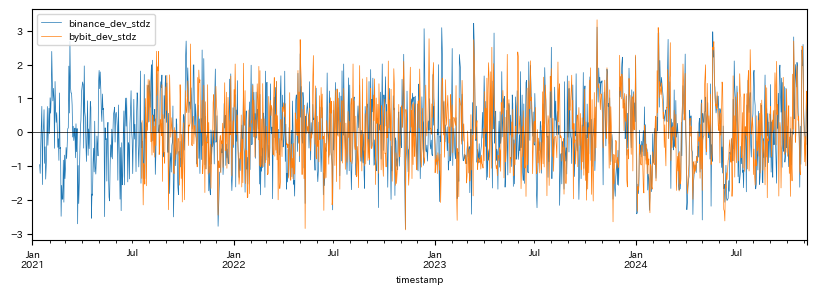

In [35]:
plt.figure(figsize=(10, 3))
df['binance_dev_stdz'].plot(lw=0.5)
df['bybit_dev_stdz'].plot(lw=0.5)
plt.legend()
plt.axhline(0, color='k', lw=0.5);

- 相関をチェック

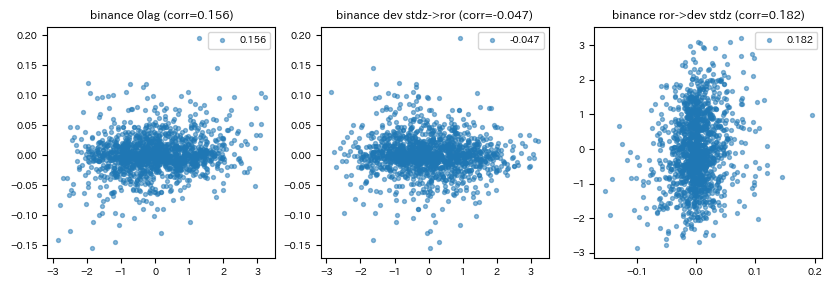

In [36]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plot_corr(df['binance_dev_stdz'], df['binance_perp_ror'], title='binance 0lag')
plt.subplot(1, 3, 2)
plot_corr(df['binance_dev_stdz'].shift(1), df['binance_perp_ror'], title='binance dev stdz->ror')
plt.subplot(1, 3, 3)
plot_corr(df['binance_perp_ror'].shift(1), df['binance_dev_stdz'], title='binance ror->dev stdz')
plt.show()

In [37]:
# 比較用

- 相関係数はさほど変わっていない。

- が、損益曲線を確認すると、改善が見られる

## 戦略3

- 前日の標準化済み乖離がマイナスであればロング、プラスであればショート（標準化済み乖離に逆張り）

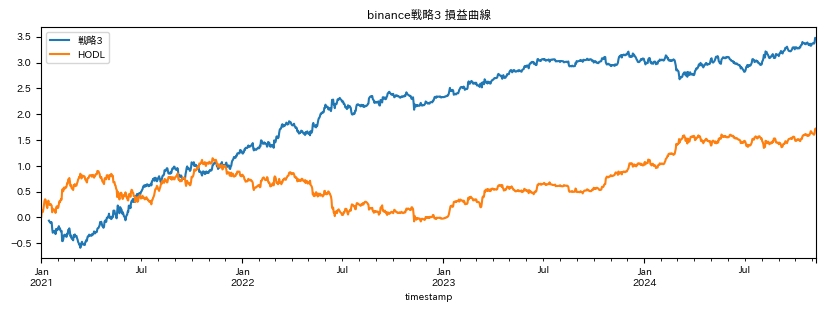

In [38]:
strategy3 = df.copy()
strategy3['binance_dev_stdz_s1'] = strategy3['binance_dev_stdz'].shift(1)
strategy3['signal'] = -np.sign(strategy3['binance_dev_stdz_s1'])
strategy3['pnl'] = strategy3['binance_perp_ror'] * strategy3['signal']

plt.figure(figsize=(10, 3))
plt.title('binance戦略3 損益曲線')
strategy3['pnl'].cumsum().plot(label='戦略3')
strategy3['binance_perp_ror'].cumsum().plot(label='HODL')
plt.legend();

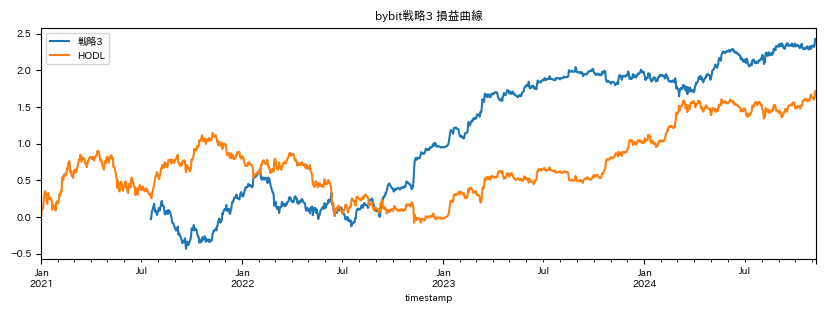

In [39]:
strategy3 = df.copy()
strategy3['bybit_dev_stdz_s1'] = strategy3['bybit_dev_stdz'].shift(1)
strategy3['signal'] = -np.sign(strategy3['bybit_dev_stdz_s1'])
strategy3['pnl'] = strategy3['bybit_perp_ror'] * strategy3['signal']

plt.figure(figsize=(10, 3))
plt.title('bybit戦略3 損益曲線')
strategy3['pnl'].cumsum().plot(label='戦略3')
strategy3['bybit_perp_ror'].cumsum().plot(label='HODL')
plt.legend();

- まずまず良好な結果を得られた。

## 知見

- 指標の性能は相関係数だけではなく、損益曲線でプロットしてみる
  - 値幅の大きいところで正答率が高ければ、よい結果が得られることがある
  - 時期に応じて効く・効かないの差が激しくないかを確認できる

# まとめ

- デリバティブとの価格乖離は、市況の過熱度合いを表し、指標となりうる。
- ただ、価格乖離はある一箇所の数値だけを見ても短期的な価格の方向性が分かりづらい。
  - 現時点でマイナスだからどう、ではなく、ここ最近に比べて高いか低いか、という相対的な情報が重要。
- 現物-デリバティブ乖離は使えそうな指標としてストックしておく。